#                 Arrhythmia Beat Classification

## Step 0 : Lecture d'un enregistrement d'ECG et la preparation des donnees 

Nous allons utiliser les donnees ecg du MIT que vous pouvez telecharger en suivant le liens : https://physionet.org/physiobank/database/mitdb/ 

                Importation des modules 
 Veuillez a telecharger tous les modules  surtout le premier avec 
                    **pip install wfdb**
                    et aussi le module tqdm
                    **pip install tqdm**

In [1]:
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
import os
import h5py
import pandas as pd
from glob import glob
from scipy import signal as ss
from matplotlib import pyplot as plt

    Choisir le fichier a lire et a afficher dans un graphique 

In [2]:
FILE=1                # Il  y'a 48 fichier au total donc choisir entre 0 et 47 comme c'est dans une liste.
CHANNEL=0             # Il y a deux canaux
SAMPLE_START=114000   # Début de l'échantillon dans le fichier
SAMPLE_SIZE=4000      # Nombre de lectures (360 par seconde)

In [3]:
def get_records():
    """ Get paths for data in data/mit/ directory """
    # Download if doesn't exist
    if not os.path.isdir('data/mitdb'):
        print ('Downloading the mitdb ecg database, please wait')
        ud.download_mitdb()
        print ('Download finished')

    # There are 3 files for each record
    # *.atr is one of them
    #The glob module finds all the pathnames matching a specified 
    #    pattern according to the rules used by the Unix shell
    paths = glob('data/mitdb/*.atr')

    # Get rid of the extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

In [4]:
# Get available data files by using the previous function get_record().
dbfiles = get_records()
print('Total files: ', len(dbfiles))

# Pick a file.
datfile = dbfiles[FILE]
print('Loading file:', datfile)

# Read the file.
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Info about the data.
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

Total files:  48
Loading file: data/mitdb/101
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1874


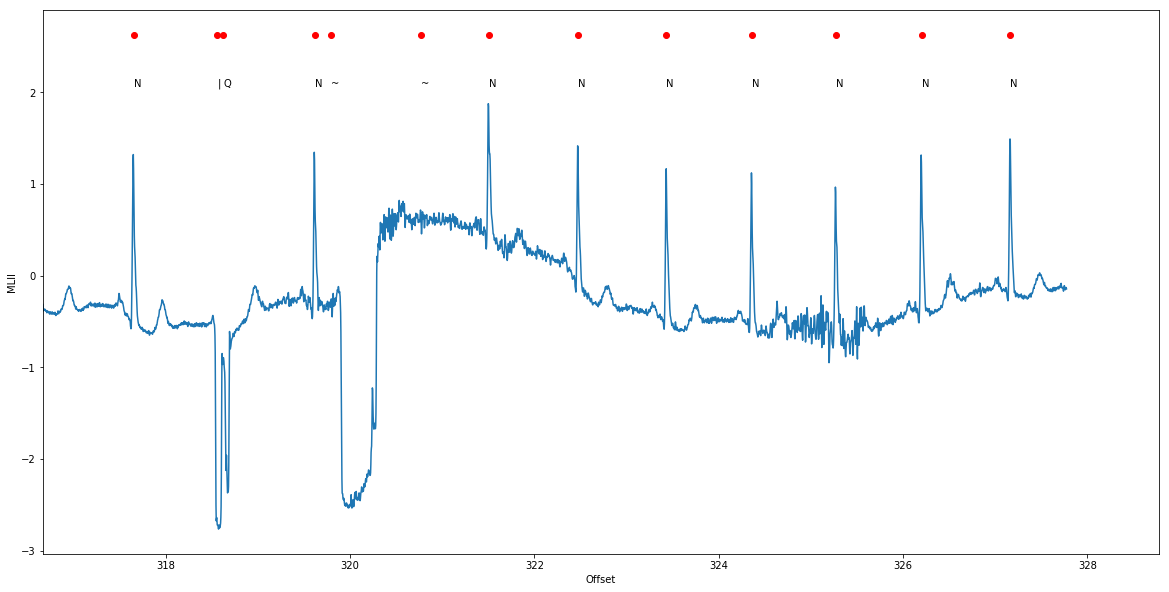

In [5]:
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Get data and annotations for the samples selected below.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Plot the heart beats. Time scale is number of readings
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# Extract annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Annotation codes.
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.show()